Using the tutorial "How to Build a Pairs Trading Strategy on Quantopian" applied to finding trading pairs among rental companies, United Rentals, Herc Holdings, Ryder Systems, HE Equipment Services and the SPY (S&P 500 ETF). ADRs did not work and did not try using local symbols.

This method was taken to look through a list of securities and test for cointegration between all pairs. It returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than 0.05

In [2]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint

np.random.seed(100)

import matplotlib.pyplot as plt

In [3]:
def find_cointegrated_pairs(securities_panel):
    n = len(securities_panel.minor_axis)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = securities_panel.keys
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = securities_panel.minor_xs(securities_panel.minor_axis[i])
            S2 = securities_panel.minor_xs(securities_panel.minor_axis[j])
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((securities_panel.minor_axis[i], securities_panel.minor_axis[j]))
    return score_matrix, pvalue_matrix, pairs

Looking for cointegrated pairs of rental stocks from January 2010 to March 2017.

In [4]:
symbol_list = ['URI', 'HRI', 'R', 'HEES','SPY']
securities_panel = get_pricing(symbol_list, fields=['price']
                               , start_date='2010-01-01', end_date='2017-03-31')
securities_panel.minor_axis = map(lambda x: x.symbol, securities_panel.minor_axis)

In [5]:
securities_panel.loc['price'].head(5)

,URI,HRI,R,HEES,SPY
2010-01-04 00:00:00+00:00,10.05,35.67,35.253,6.053,98.473
2010-01-05 00:00:00+00:00,9.92,35.40,34.633,5.891,98.743
2010-01-06 00:00:00+00:00,9.91,34.92,34.183,5.924,98.838
2010-01-07 00:00:00+00:00,9.81,34.95,33.530,6.064,99.238
2010-01-08 00:00:00+00:00,9.60,36.54,34.251,6.148,99.560


In [6]:
securities_panel.minor_xs('SPY').head(5)

,price
2010-01-04 00:00:00+00:00,98.473
2010-01-05 00:00:00+00:00,98.743
2010-01-06 00:00:00+00:00,98.838
2010-01-07 00:00:00+00:00,99.238
2010-01-08 00:00:00+00:00,99.560


After running, it looks like HRI and HEES are cointegrated in the heatmap, but we can examine the prices to validate.

[]


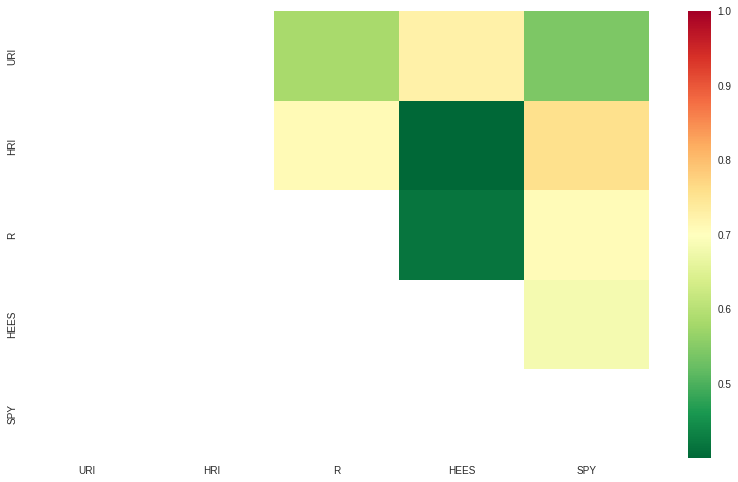

In [7]:
scores, pvalues, pairs = find_cointegrated_pairs(securities_panel)
import seaborn
seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.95)
                )

print pairs

There does not appear to be any pairs with p-values less than 0.05, but the "best" pair is selected.

In [8]:
S1 = securities_panel.loc['price']['HRI']
S2 = securities_panel.loc['price']['HEES']

In [9]:
score, pvalue, _ = coint(S1, S2)
pvalue

0.40053842114034222

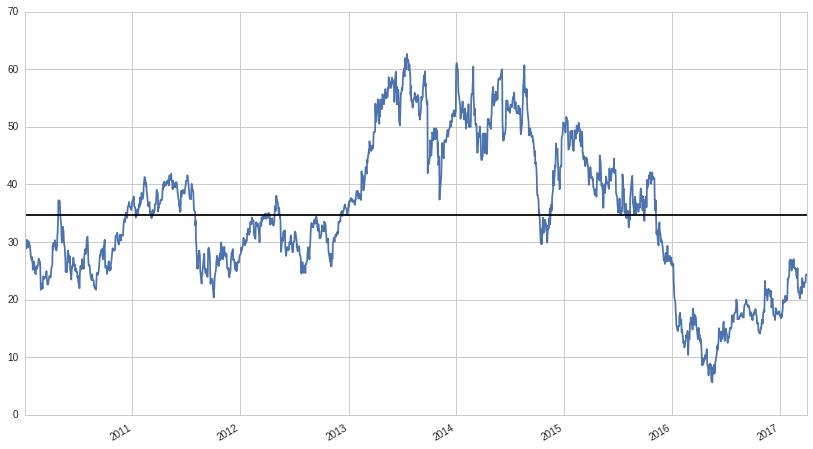

In [10]:
diff_series = S1 - S2
diff_series.plot()
plt.axhline(diff_series.mean(), color='black')

In [11]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

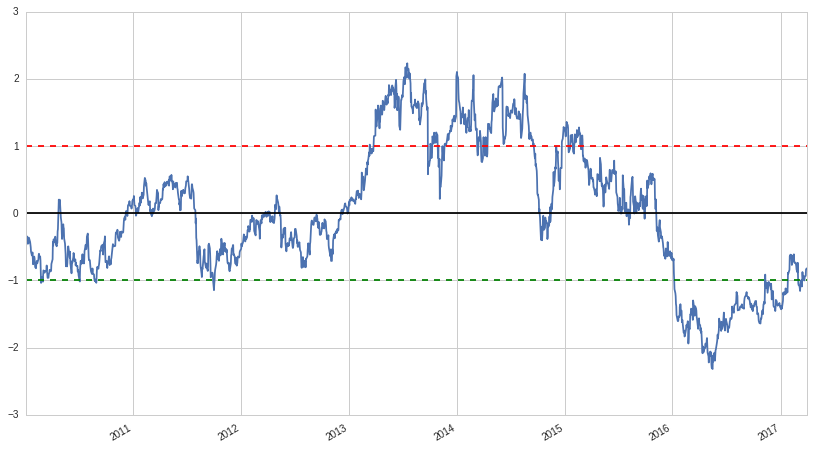

In [12]:
zscore(diff_series).plot()
plt.axhline(zscore(diff_series).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')


For simplicity, the signal is normalized as a z-score. The simple strategy is to go long the spread whenever the z-score is below -1 and go short the spread when the z-score is above 0. Exit positions when the z-score approaches 0.

In [ ]:
We can look at the 10 and 50 day moving averages differences as well as the differnce in prices of the two stocks

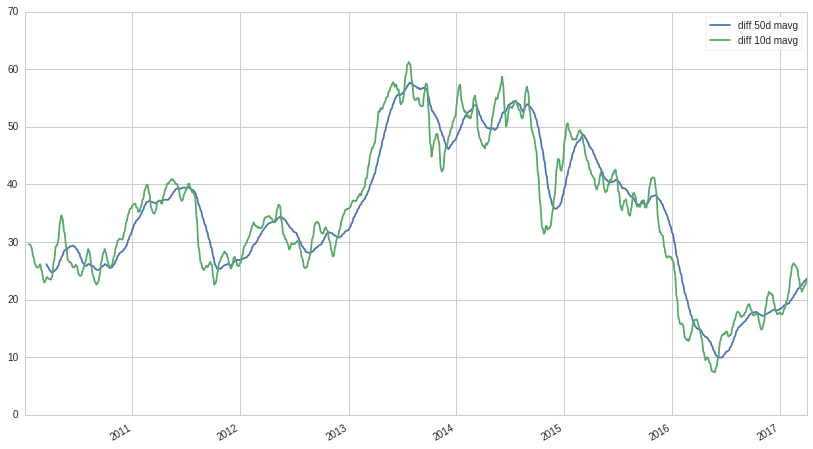

In [17]:
difference = S1 - S2
difference.name = 'diff'

diff_mavg10 = pd.rolling_mean(difference, window=10)
diff_mavg10.name = 'diff 10d mavg'

diff_mavg50 = pd.rolling_mean(difference, window=50)
diff_mavg50.name = 'diff 50d mavg'

pd.concat([diff_mavg50, diff_mavg10], axis=1).plot()

We can use the moving averages to compute the z-score of the difference at each given time. This will tell us how extreme the difference is and whether it's a good idea to enter a position at this time. Let's take a look at the z-score now.

In [ ]:
Take a rolling 50 day standard deviation and compute the z-score for each day

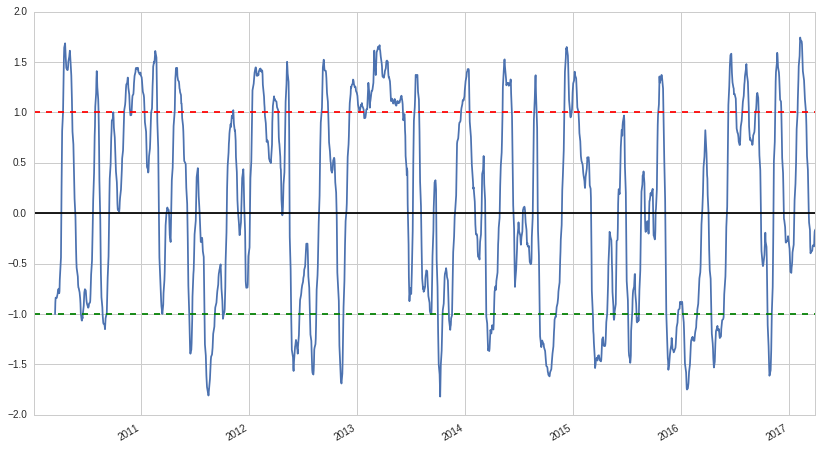

In [18]:
std_50 = pd.rolling_std(difference, window=50)
std_50.name = 'std 50d'

zscore_50_10 = (diff_mavg10 - diff_mavg50)/std_50
zscore_50_10.name = 'z-score'
zscore_50_10.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')

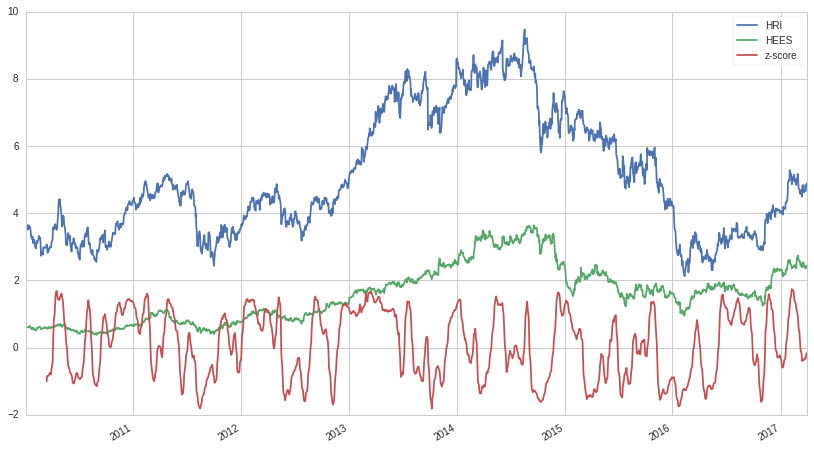

In [19]:
two_stocks = securities_panel.loc['price'][['HRI', 'HEES']]
pd.concat([two_stocks/10, zscore_50_10], axis=1).plot()

The tutorial suggested looking at topics such as the Augmented-Dickey Fuller Test, Hurst exponent, half-life of mean reversion inferred from an Ornstein-Uhlenbeck process and Kalman filters. My understanding of these concepts is very limited and through a search found another algorithm that incorporates these concepts. I took the two stocks from the above excercise and plugged it into the cloned algorithm. I adjusted some of the parameters and will submit the best result which is still not very good.

In [10]:
#Cloned from "Pair Trade with Cointegration and Mean-Reversion Tests"
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import pandas as pd
from zipline.utils import tradingcalendar
import pytz


def initialize(context):
    '''
    START: USER CONFIGURABLE PARAMETERS FOR THE BACKTEST
    '''
    # Quantopian backtester specific variables
    set_slippage(slippage.VolumeShareSlippage(volume_limit=0.025, price_impact=0.1))
    set_commission(commission.PerShare(cost=0.0075, min_trade_cost=0.0))
    #set_slippage(slippage.VolumeShareSlippage(volume_limit=0.99, price_impact=0.0))
    #set_commission(commission.PerShare(cost=0.00, min_trade_cost=0.0))
    
    # the ticker symbols for your pair
    context.y = symbol('HEES')
    context.x = symbol('HRI')
    
    # strategy specific variables
    context.lookback = 20     # used for regression
    context.z_window = 20     # used for zscore calculation, must be <= lookback
    context.entry_z = 0.5     # trade entry triggered when spread is + or - entryZ
    context.exit_z = 0.0      # trade exit triggered when spread is + or - entryZ
    context.momentum_or_mean_reversion = 'mean-reversion'     # 'momentum' or 'mean-reversion'
    # This defines whether to use a hedge ratio computed N periods ago. 
    # Rationale for this is that since the algo is trading off of mean reversion
    # that a hedge ratio that excludes N days of recency, e.g. when severe divergences 
    # could have occured, and which this algo hopes to exploit,  may be more aligned
    # to the economic historical relationship befitting of the stock pair
    context.use_hedge_ratio_lag = True
    context.hedge_ratio_lag = 2
    
    
    ####### START: TRADING FREQUENCY DEFINTIONS #####
    context.trade_freq = 'daily'             # 'daily' or 'intraday'
    
    ### START: DAILY FREQUENCY PARAMETERS
    # if context.trade_freq == 'intraday' then specify these inputs
    # only run the trading logic at 3:30 Eastern time, which 30-minutes before market closes
    context.daily_run_logic_hours = 15          # only used if context.trade_freq='daily' 
    context.daily_run_logic_minutes = 30        # only used if context.trade_freq='daily'
    ### END: DAILY FREQUENCY PARAMETERS
    
    ### START: INTRADAY FREQUENCY PARAMETERS
    # if context.trade_freq == 'intraday' then specify these inputs
    context.intraday_freq = 15             # only used if context.trade_freq='intraday'
    context.run_trading_logic_freq = 60    # only used if context.trade_freq='intraday'
    context.check_exit_every_minute = False    # if True, and if in a trade, will check every minute whether to exit
    ### END: INTRADAY FREQUENCY PARAMETERS
    
    ####### END: TRADING FREQUENCY DEFINTIONS #####
    
    
    ####### START: STATISTICAL FILTERS DEFINITIONS #####
    # Specify 'statistical filters' (e.g. cointegration, half-life of mean reversion, etc) 
    # that the pair's spread must pass before before it will be considered for a trade
    context.stat_filter = {}
    context.stat_filter['adf_p_value'] = {}
    context.stat_filter['adf_critical_value'] = {}
    context.stat_filter['half_life_days'] = {}
    context.stat_filter['hurst_exponent'] = {}
    
    context.stat_filter['adf_p_value']['use'] = True
    context.stat_filter['adf_p_value']['lookback'] = 63
    context.stat_filter['adf_p_value']['function'] = adf_p_value    # function defined below
    context.stat_filter['adf_p_value']['test_condition_min'] = 0.0
    context.stat_filter['adf_p_value']['test_condition_max'] = 0.20
    
    context.stat_filter['adf_critical_value']['use'] = False
    context.stat_filter['adf_critical_value']['lookback'] = 63
    context.stat_filter['adf_critical_value']['function'] = adf_critical_value_test    # function defined below
    context.stat_filter['adf_critical_value']['test_condition_min'] = int(0)           # see function description for return values
    context.stat_filter['adf_critical_value']['test_condition_max'] = int(10)          # see function description for return values
    
    context.stat_filter['half_life_days']['use'] = True
    context.stat_filter['half_life_days']['lookback'] = 126
    context.stat_filter['half_life_days']['function'] = half_life    # function defined below
    context.stat_filter['half_life_days']['test_condition_min'] = 1.0
    context.stat_filter['half_life_days']['test_condition_max'] = 42.0
    
    context.stat_filter['hurst_exponent']['use'] = False
    context.stat_filter['hurst_exponent']['lookback'] = 126
    context.stat_filter['hurst_exponent']['function'] = hurst        # function defined below
    context.stat_filter['hurst_exponent']['test_condition_min'] = 0.0
    context.stat_filter['hurst_exponent']['test_condition_max'] = 0.4
    ####### END: STATISTICAL FILTERS DEFINITIONS #####
    
    '''
    END: USER CONFIGURABLE PARAMETERS
    '''
    
    # define a few more global variables based on the inputs above
    context.intraday_history_lookback =  context.lookback * context.intraday_freq + 10
    context.spread = np.array([])
    context.hedge_ratio_history = np.array([])
    context.in_long = False
    context.in_short = False

    if not context.use_hedge_ratio_lag:
        # a lag of 1 means to include the most recent price in the hedge_ratio calculation
        # specificlly, this is used for np.array[-1] indexing
        context.hedge_ratio_lag = 1
        
# Will be called on every trade event for the securities you specify. 
def handle_data(context, data):
    if get_open_orders():
        return
    now = get_datetime()
    exchange_time = now.astimezone(pytz.timezone('US/Eastern'))
    
    # Only trade N-minutes before market close
    if context.trade_freq == 'daily':
        if not (exchange_time.hour == context.daily_run_logic_hours and exchange_time.minute == context.daily_run_logic_minutes):
            return
    
    if context.trade_freq == 'intraday':
        # Only run trading logic every N minutes
        if exchange_time.minute % context.run_trading_logic_freq > 0:
            return
    
    if context.trade_freq == 'daily':
        prices = data.history([context.x, context.y], 'price', context.lookback, '1d').iloc[-context.lookback::]
    
    if context.trade_freq == 'intraday':
        prices = data.history([context.x, context.y], 'price', context.intraday_history_lookback, '1m')
        indexes_at_freq = range(prices.shape[0]-1, 0, -context.intraday_freq)
        indexes_at_freq.sort()
        prices = prices.ix[ indexes_at_freq, :]

    y = prices[context.y]
    x = prices[context.x]

    try:
        hedge = hedge_ratio(y, x, add_const=True)      
    except ValueError as e:
        log.debug(e)
        return
    
    context.hedge_ratio_history = np.append(context.hedge_ratio_history, hedge)
    # Calculate the current day's spread and add it to the running tally
    if context.hedge_ratio_history.size < context.hedge_ratio_lag:
        return
    # Grab the previous day's hedge ratio
    hedge = context.hedge_ratio_history[-context.hedge_ratio_lag]  
    context.spread = np.append(context.spread, y[-1] - hedge * x[-1])
    spread_length = context.spread.size
    #record(spd=context.spread[-1])
    
    # apply all the statistical filters to 'context.spread', if specified in initialize() 
    # only test for trading triggers if the spread passes all specified criteria
    for stat_name in context.stat_filter:
        if context.stat_filter[stat_name]['use']:
            test_lookback = context.stat_filter[stat_name]['lookback']
            if spread_length < test_lookback:
                return   
            test_spread = context.spread[-test_lookback:]
            test_func = context.stat_filter[stat_name]['function']
            test_value = test_func(test_spread)
            test_min = context.stat_filter[stat_name]['test_condition_min']
            test_max = context.stat_filter[stat_name]['test_condition_max']
            
            if stat_name == 'adf_p_value':
                record(adf_p=test_value)
            if stat_name == 'adf_critical_value':
                record(adf_cv=test_value)
            if stat_name == 'half_life_days':
                record(half_life=test_value)
            if stat_name == 'hurst_exponent':
                record(hurst=test_value)
            if (test_value < test_min) or (test_value > test_max):
                return
        
    if context.spread.size > context.z_window:
        # Keep only the z-score lookback period
        spreads = context.spread[-context.z_window:]
        
        zscore = (spreads[-1] - spreads.mean()) / spreads.std()
        record(Z=zscore)
        #record(gr_lev=context.account.leverage, net_lev=context.account.net_leverage)
          
        if context.in_short and zscore < context.exit_z:
            order_target(context.y, 0)
            order_target(context.x, 0)
            context.in_short = False
            context.in_long = False
            #record(in_trade=0)
            #record(stock_Y_pct=0, stock_X_pct=0)
            return
        
        if context.in_long and zscore > context.exit_z:
            order_target(context.y, 0)
            order_target(context.x, 0)
            context.in_short = False
            context.in_long = False
            #record(in_trade=0)
            #record(stock_Y_pct=0, stock_X_pct=0)
            return
        
         
            
        # only check for new trades every N minutes, but can exit existing trades _each_ minute
        # which is why this check is here. Trade exits are handled above.
        #if exchange_time.minute % context.run_trading_logic_freq > 0:
        #    return
        
        if zscore < -context.entry_z and (not context.in_long):
            # Only trade if NOT already in a trade
            y_target_shares = 1
            x_target_shares = -hedge
            context.in_long = True
            context.in_short = False
            
            (y_target_pct, x_target_pct) = compute_holdings_pct(y_target_shares,
                                                                x_target_shares, 
                                                                y[-1], x[-1] )
            
            if context.momentum_or_mean_reversion == 'momentum':
                y_target_pct = -1.0 * y_target_pct
                x_target_pct = -1.0 * x_target_pct
                
            order_target_percent(context.y, y_target_pct)
            order_target_percent(context.x, x_target_pct)
            #record(in_trade=1)
            #record(stock_Y_pct=y_target_pct, stock_X_pct=x_target_pct)
            return

        if zscore > context.entry_z and (not context.in_short):
            # Only trade if NOT already in a trade
            y_target_shares = -1
            x_target_shares = hedge    
            context.in_short = True
            context.in_long = False
           
            (y_target_pct, x_target_pct) = compute_holdings_pct(y_target_shares, 
                                                                x_target_shares, 
                                                                y[-1], x[-1] )
            
            if context.momentum_or_mean_reversion == 'momentum':
                y_target_pct = -1.0 * y_target_pct
                x_target_pct = -1.0 * x_target_pct
                
            order_target_percent(context.y, y_target_pct)
            order_target_percent(context.x, x_target_pct)
            #record(in_trade=1)
            #record(stock_Y_pct=y_target_pct, stock_X_pct=x_target_pct)

def is_market_close(dt):
    ref = tradingcalendar.canonicalize_datetime(dt)
    return dt == tradingcalendar.open_and_closes.T[ref]['market_close']

def hedge_ratio(y, x, add_const=True):
    if add_const:
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        return model.params[1]
    model = sm.OLS(y, x).fit()
    return model.params.values
    
def compute_holdings_pct(y_shares, x_shares, y_price, x_price):
    y_dollars = y_shares * y_price
    x_dollars = x_shares * x_price
    notional_dollars =  abs(y_dollars) + abs(x_dollars)
    y_target_pct = y_dollars / notional_dollars
    x_target_pct = x_dollars / notional_dollars
    return (y_target_pct, x_target_pct)

def adf_p_value(input_ts):
    # returns p-value from Augmented Dickey-Fullet test for cointegration, with lag=1
    return ts.adfuller(input_ts, 1)[1]

def adf_critical_value_test(input_ts):
    # returns 1: if the t-stat of the ADF-test is less than the 1% critical value
    # returns 5: if the t-stat of the ADF-test is less than the 5% critical value (but greater than the 1% level)
    # returns 10: if the t-stat of the ADF-test is less than the 10% critical value (but greater than the 1% and 5% levels)
    # return 99: if the t-stat of the ADF-test is greater than the 10% critical value
    adf_test = ts.adfuller(input_ts, 1)
    t_stat = adf_test[0]
    critical_values = adf_test[4]
    if t_stat < critical_values['1%']:
        return int(1)
    if t_stat < critical_values['5%']:
        return int(5)
    if t_stat < critical_values['10%']:
        return int(10)
    return int(99)

def half_life(input_ts):
    # returns the [theoretical, based on OU-process equations] number of periods to expect 
    # to have to wait for the spread to mean-revert half the distance to its mean
    price = pd.Series(input_ts)  
    lagged_price = price.shift(1).fillna(method="bfill")  
    delta = price - lagged_price  
    beta = np.polyfit(lagged_price, delta, 1)[0] 
    half_life = (-1*np.log(2)/beta) 
    return half_life

def hurst(input_ts, lags_to_test=20):  
    # interpretation of return value
    # hurst < 0.5 - input_ts is mean reverting
    # hurst = 0.5 - input_ts is effectively random/geometric brownian motion
    # hurst > 0.5 - input_ts is trending
    tau = []
    lagvec = []  
    #  Step through the different lags  
    for lag in range(2, lags_to_test):  
        #  produce price difference with lag  
        pp = np.subtract(input_ts[lag:], input_ts[:-lag])  
        #  Write the different lags into a vector  
        lagvec.append(lag)  
        #  Calculate the variance of the differnce vector  
        tau.append(np.sqrt(np.std(pp)))  
    #  linear fit to double-log graph (gives power)  
    m = np.polyfit(np.log10(lagvec), np.log10(tau), 1)  
    # calculate hurst  
    hurst = m[0]*2   
    return hurst